---
## Importing

In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from geopy import Nominatim

import urllib.request
import json
from pandas import json_normalize

import folium

import time

In [5]:
nomi_obj = Nominatim(user_agent='Coursera_Student')

In [6]:
pd.set_option('display.max_rows', 500)

### Cleaning Function

In [7]:
def is_not_in(dfs):

    unis = [dfs[i]['bairros'].unique() for i in range(len(dfs))]

    not_in = []
    for i in range(len(dfs)):
        for j in range(len(dfs)):
        
            if i!=j:
            
                not_in.append([i, j, unis[i][[str(o).lower().strip().replace('á','a')
                                              .replace('é','e')
                                              .replace('í','i')
                                              .replace('ó','o')
                                              .replace('ú','u') not in [str(l).lower().strip().replace('á','a')
                                                                         .replace('é','e')
                                                                         .replace('í','i')
                                                                         .replace('ó','o')
                                                                         .replace('ú','u') for l in unis[j].tolist()] for o in unis[i].tolist()]]])

    return not_in
            

### Mapping Functions

In [8]:
def plot_map(df, zoom=9):
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start = zoom)


    for lat, lng, label in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=3,
                            color='darkorange',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [9]:
def plot_map_lite(df, zoom=9):
    
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label in zip(df['lat'].values, df['lng'].values, df['bairros'].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.CircleMarker([lat, lng],
                            #popup=label,
                            radius=2,
                            color='black',
                            #fill=True,
                            #fill_color='blue',
                            #fill_oppacity=0.8
                           ).add_to(mapa)
    return mapa

In [10]:
def plot_search_map(df, zoom=10):
    
     
    mapa = folium.Map(location = [-22.911014, -43.209373], zoom_start=zoom)

    for lat, lng, label, radius in zip(df['lat'].values, df['lng'].values, df.iloc[:, 0].values, df['radius'].values):
    
        #label = folium.Popup(label, html_parser=True)
        folium.Circle([lat, lng],
                      #popup=label,
                      radius=radius,
                      color='darkred',
                      #fill=True,
                      #fill_color='blue',
                      #fill_oppacity=0.8
                     ).add_to(mapa)
    return mapa
    

# Loading 

### Hoods Info:

In [11]:
hoods = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\Clean\\complete_bairros.csv').drop('Unnamed: 0', axis=1)

### Hoods Search, Exploration and Categories Search:

In [12]:
hood_search = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_search.csv', index_col=0)

In [13]:
hood_explore = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_explore.csv', index_col=0)

In [14]:
hood_ctgrs = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\\rio dataframes\\Search Results\\hoods_ctgrs.csv', index_col = 0)

### Population

In [15]:
pops = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\Clean\\economia\\pops_clean_fixed.csv', index_col=0)

# Cleaning

In [18]:
hood_ctgrs.rename(columns={'location.lat':'lat', 'location.lng':'lng'}, inplace=True)

In [19]:
hood_ctgr = hood_ctgrs.drop_duplicates(subset=['bairros', 'id'])

In [20]:
pops.rename(columns={'Bairros':'bairros'}, inplace=True)

In [ ]:
pops['bairros'][114] = 'freguesia (ilha do governador)'
pops['bairros'][151] = 'freguesia (jacarepaguá)'
pops['bairros'][17] = 'imperial de são cristóvão'

# Population

In [22]:
young = pd.concat([pops['bairros'], pops[[ '16 e 17 anos', '18 e 19 anos', '20 a 24 anos', '25 a 29 anos']].T.sum().T], axis=1)

In [23]:
young.columns = ['bairros', '16 e 29 anos']

# Gym Data

In [24]:
gym = hood_ctgr[hood_ctgr['category']=='Gym / Fitness Center'].groupby('bairros').count()['id'].reset_index()

In [25]:
gym = pd.merge(gym, hoods[['bairros', 'area']], on='bairros')

In [26]:
gym['gym/Km2'] = gym['id']/gym['area']*1000000

In [27]:
gym.rename(columns={'id':'gyms'}, inplace=True)

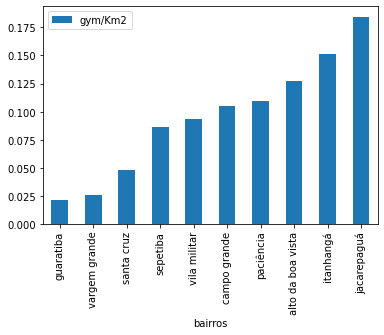

In [28]:
gym[['bairros', 'gym/Km2']].sort_values(by='gym/Km2').head(10).plot.bar(x='bairros')

# Combining

In [29]:
data = pd.merge(gym, young, on='bairros').set_index('bairros')

In [30]:
data['pop/Km2'] = (data['16 e 29 anos'] / data['area']) * 1000000

In [31]:
data['gym/pop'] = (data['gyms'] / data['16 e 29 anos']) * 10000      # Number of gyms per 10000 inhabitants

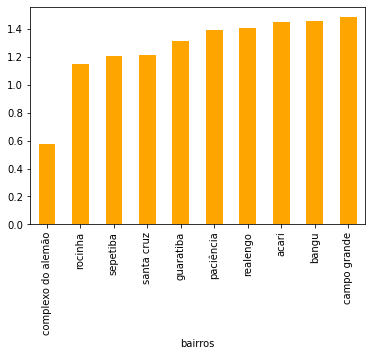

In [32]:
data.sort_values(by='gym/pop')['gym/pop'].head(10).plot.bar(color='orange')

# Mapping

In [101]:
bottom_pop = data.sort_values(by='gym/pop').head(10).index.values

In [122]:
bottom_km = data.sort_values(by='gym/Km2').head(10).index.values

In [ ]:
plot_map_lite(hoods[hoods['bairros'].isin(bottom_pop)])

In [ ]:
plot_map_lite(hoods[hoods['bairros'].isin(bottom_km)])

# Distributions

In [33]:
from sklearn.preprocessing import MinMaxScaler as mms

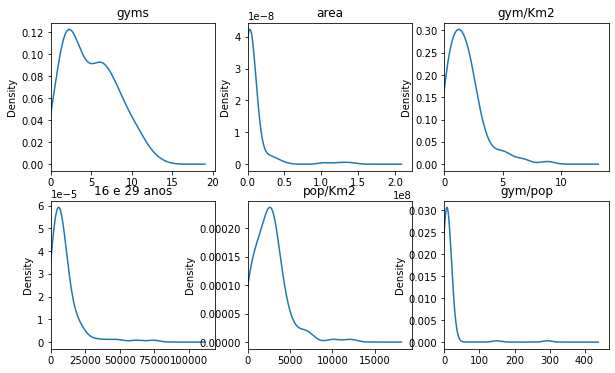

In [34]:
fig = plt.figure(figsize=(10,6))
axes = [fig.add_subplot(2,3,i) for i in range(1, 7)]

for i in range(1,7):
    
    data.iloc[:, i-1].plot(kind='kde', ax=axes[i-1], xlim=(0), title=data.columns[i-1])
    
    

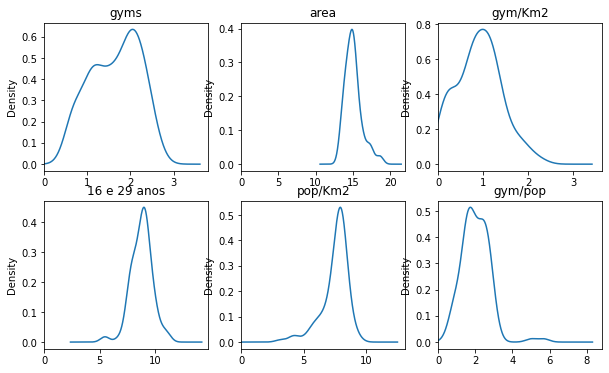

In [35]:
fig = plt.figure(figsize=(10,6))
axes = [fig.add_subplot(2,3,i) for i in range(1, 7)]

for i in range(1,7):
    
    data.iloc[:, i-1].apply(np.log1p).plot(kind='kde', ax=axes[i-1], xlim=(0), title=data.columns[i-1])
    
    

# Clustering

In [36]:
from sklearn.cluster import KMeans

##  Optimization

In [37]:
scrs = []
for i in range(1, 15):
    
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20).fit(data)
    scrs.append([i, kmeans.inertia_])

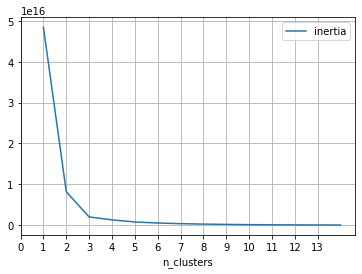

In [38]:
pd.DataFrame(scrs, columns=['n_clusters', 'inertia']).plot(x='n_clusters', y='inertia', xticks=np.arange(0,14,1))
plt.grid()

## All Variables Log-Transformed

In [40]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20).fit(data.apply(np.log1p))
data['cluster'] = kmeans.labels_
clus_mean = data.groupby('cluster').mean()

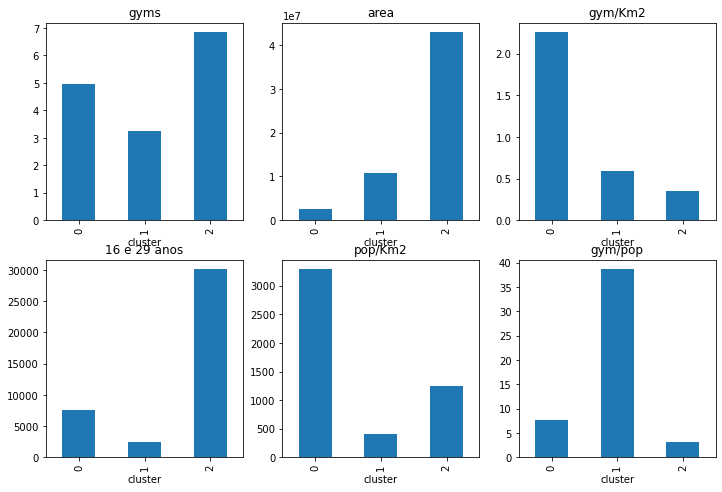

In [41]:
fig = plt.figure(figsize=(12,8))
axes = [fig.add_subplot(2,3,i) for i in range(1, 7)]

for i, col in enumerate(clus_mean):
    clus_mean[col].plot(kind='bar', ax=axes[i], title=col)

# Only gym/pop, gym/Km2, pop/Km2 and area Scaled

In [44]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20).fit(mms().fit_transform(data[['gym/pop', 'gym/Km2', 'pop/Km2', 'area']]))
data['cluster'] = kmeans.labels_
clus_mean = data.groupby('cluster').mean()

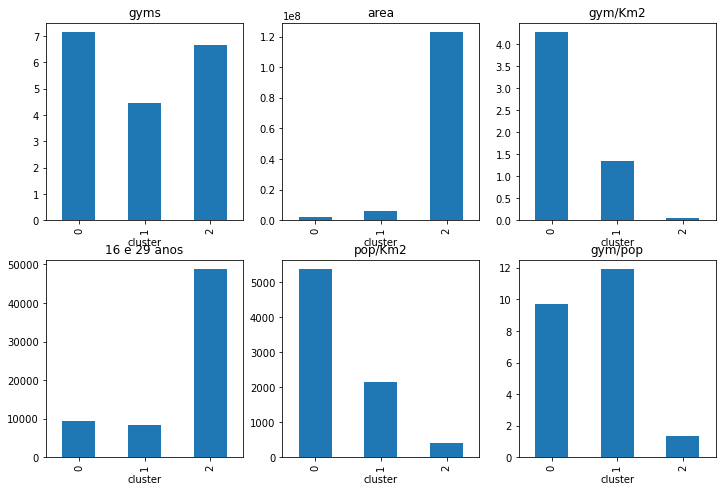

In [45]:
fig = plt.figure(figsize=(12,8))
axes = [fig.add_subplot(2,3,i) for i in range(1, 7)]

for i, col in enumerate(clus_mean):
    clus_mean[col].plot(kind='bar', ax=axes[i], title=col)

### Conclusion: Besides looking at the number of gyms per 10000 inhabitants, it's also important to consider the population per Km2, once high values of this measure lead to an increase of the likelihood of getting new clients, given that the population will be more heavily concentrated around the new gym.

In [87]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20).fit(mms().fit_transform(data[['gym/pop', 'gym/Km2', 'pop/Km2']]))
data['cluster'] = kmeans.labels_
clus_mean = data.groupby('cluster').mean()

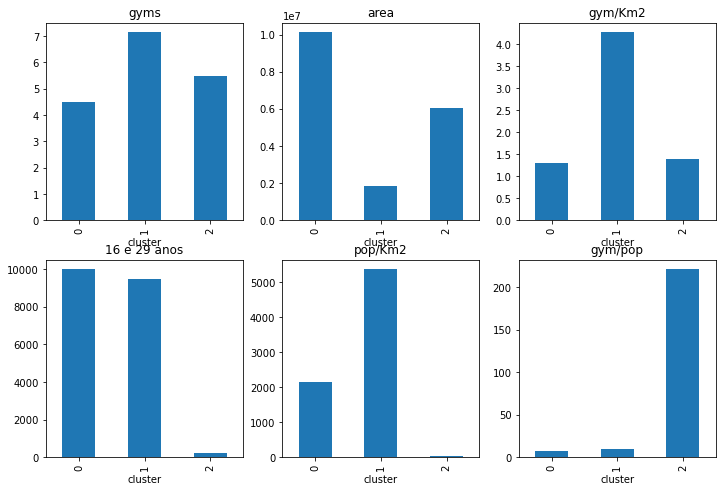

In [88]:
fig = plt.figure(figsize=(12,8))
axes = [fig.add_subplot(2,3,i) for i in range(1, 7)]

for i, col in enumerate(clus_mean):
    clus_mean[col].plot(kind='bar', ax=axes[i], title=col)

## Further Mapping

In [111]:
cluster2 = data[data['cluster']==1].copy()

In [ ]:
plot_map(hoods[hoods['bairros'].isin(cluster2.index.values)])

## Further Clustering

#### Optimization

In [90]:
scrs = []
for i in range(1, 15):
    
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=20).fit(mms().fit_transform(cluster2[['gym/pop', 'gym/Km2', 'pop/Km2']]))
    scrs.append([i, kmeans.inertia_])

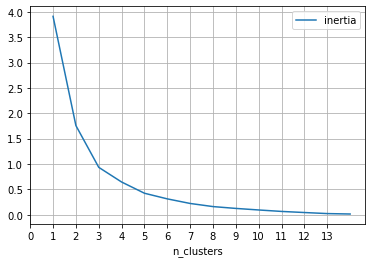

In [91]:
pd.DataFrame(scrs, columns=['n_clusters', 'inertia']).plot(x='n_clusters', y='inertia', xticks=np.arange(0,14,1))
plt.grid()

#### Clustering

In [112]:
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20).fit(cluster2[['gym/pop', 'gym/Km2', 'pop/Km2']])
cluster2['cluster'] = kmeans.labels_
clus_mean = cluster2.groupby('cluster').mean()

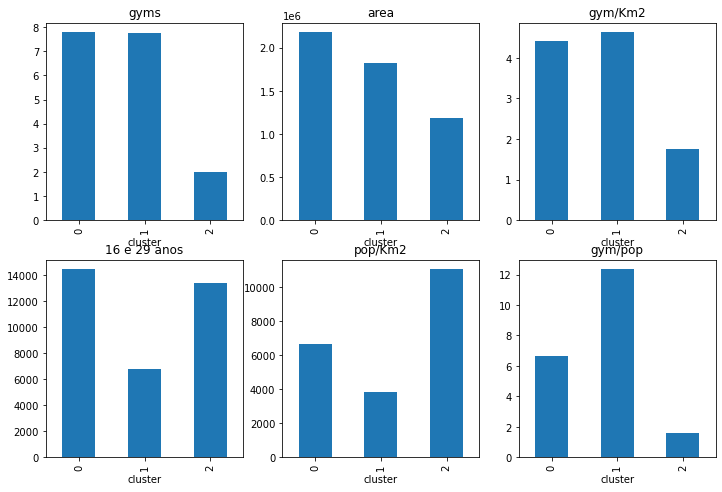

In [113]:
fig = plt.figure(figsize=(12,8))
axes = [fig.add_subplot(2,3,i) for i in range(1, 7)]

for i, col in enumerate(clus_mean):
    clus_mean[col].plot(kind='bar', ax=axes[i], title=col)

In [114]:
cluster2[cluster2['cluster'].isin([2])]

,gyms,area,gym/Km2,16 e 29 anos,pop/Km2,gym/pop,cluster
bairros,,,,,,,
jacarezinho,2,9.438741e+05,2.118927,9502.0,10067.020522,2.104820,2
rocinha,2,1.437195e+06,1.391600,17369.0,12085.348857,1.151477,2


In [110]:
cluster2

,gyms,area,gym/Km2,16 e 29 anos,pop/Km2,gym/pop,cluster
bairros,,,,,,,
abolição,4,6.163327e+05,6.490002,2603.0,4223.368640,15.366884,4
catete,6,6.810267e+05,8.810227,4551.0,6682.557057,13.183916,1
cidade de deus,3,1.273025e+06,2.356592,9397.0,7381.631433,3.192508,1
copacabana,12,4.100850e+06,2.926222,29621.0,7223.136364,4.051180,1
engenho novo,8,2.644847e+06,3.024750,10295.0,3892.474540,7.770763,0
flamengo,8,1.646254e+06,4.859519,10921.0,6633.850388,7.325337,1
ipanema,11,3.084907e+06,3.565747,9712.0,3148.230824,11.326194,0
jacarezinho,2,9.438741e+05,2.118927,9502.0,10067.020522,2.104820,3
laranjeiras,8,2.493507e+06,3.208332,10151.0,4070.972525,7.880997,0
